# Extremum Maximal Daily Precipitation

### Importing Library

In [4]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import mpl_toolkits
from itertools import chain
import pickle
from math import radians
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas
from sklearn.model_selection import GridSearchCV
%matplotlib inline
# for a progress bar on slow calculations
from ipywidgets import IntProgress
from IPython.display import display

### Importing data

In [36]:
month = 1
variable = 'EMXP'
dir_ = '/tf/Team 6 - Project/Data'

In [37]:
train = pd.read_csv(dir_+'/station_train.csv')
test = pd.read_csv(dir_+'/station_test.csv')
stations = pd.read_csv(dir_+'/Stations_SSD_Biomes.csv')
var = pd.read_csv(dir_+'/Final Data/Merged Data/'+variable+'/'+str(month).zfill(2)+'-'+variable+'.csv')

In [38]:
stations.set_index('STATION',inplace = True)
stations = pd.get_dummies(stations,prefix = '',prefix_sep = '',columns = ['BIOME_NB','BIOME_CODE'],drop_first = True,dummy_na = True)
stations = stations[stations.columns[np.r_[2:5, 4+month:4+month+3, 4+12*3+2:len(stations.columns)]]]
stations['ELEVATION'] = np.nan_to_num(stations['ELEVATION'])

### Creating train and test set

In [39]:
train_station = set(var['STATION'].values) & set(train['STATION'].values)
test_station = set(var['STATION'].values) & set(test['STATION'].values)

In [40]:
var.set_index('STATION', inplace = True)
var_train = var.loc[train_station]
var_test = var.loc[test_station]
X_train = stations.loc[train_station]
X_test = stations.loc[test_station]
Y_train = var_train['VALUE']
Y_test = var_test['VALUE']

In [10]:
X_train['STATION'] = X_train.index
X_train['WB'] = X_train['STATION'].apply(lambda x: x[:2]=='WB')
X_train = X_train[X_train['WB']==False]
X_train.drop(columns = ['STATION','WB'],inplace = True)
Y_train = Y_train[X_train.index]

In [11]:
X_test['STATION'] = X_test.index
X_test['WB'] = X_test['STATION'].apply(lambda x: x[:2]=='WB')
X_test = X_test[X_test['WB']==False]
X_test.drop(columns = ['STATION','WB'],inplace = True)
Y_test = Y_test[X_test.index]

### Adding TAVG and PRCP as Covariates

In [41]:
TAVG_model = pickle.load(open('/tf/Team 6 - Project/Model_creation/TAVG/models/'+str(month).zfill(2)+'-TAVG_model.p', 'rb'))
PRCP_model = pickle.load(open('/tf/Team 6 - Project/Model_creation/PRCP/models/'+str(month).zfill(2)+'-PRCP_model.p', 'rb'))

In [42]:
X_train['TAVG'] = TAVG_model.predict(X_train)
X_test['TAVG'] = TAVG_model.predict(X_test)

In [43]:
X_train['PRCP'] = PRCP_model.predict(X_train.drop(columns = ['TAVG']))
X_test['PRCP'] = PRCP_model.predict(X_test.drop(columns = ['TAVG']))

### Ploting the distribution of EMXP relative to PRCP

<div class="alert alert-block alert-danger"> <h1> <b><center>STOP RUNNING</center> </b></h1> </div>

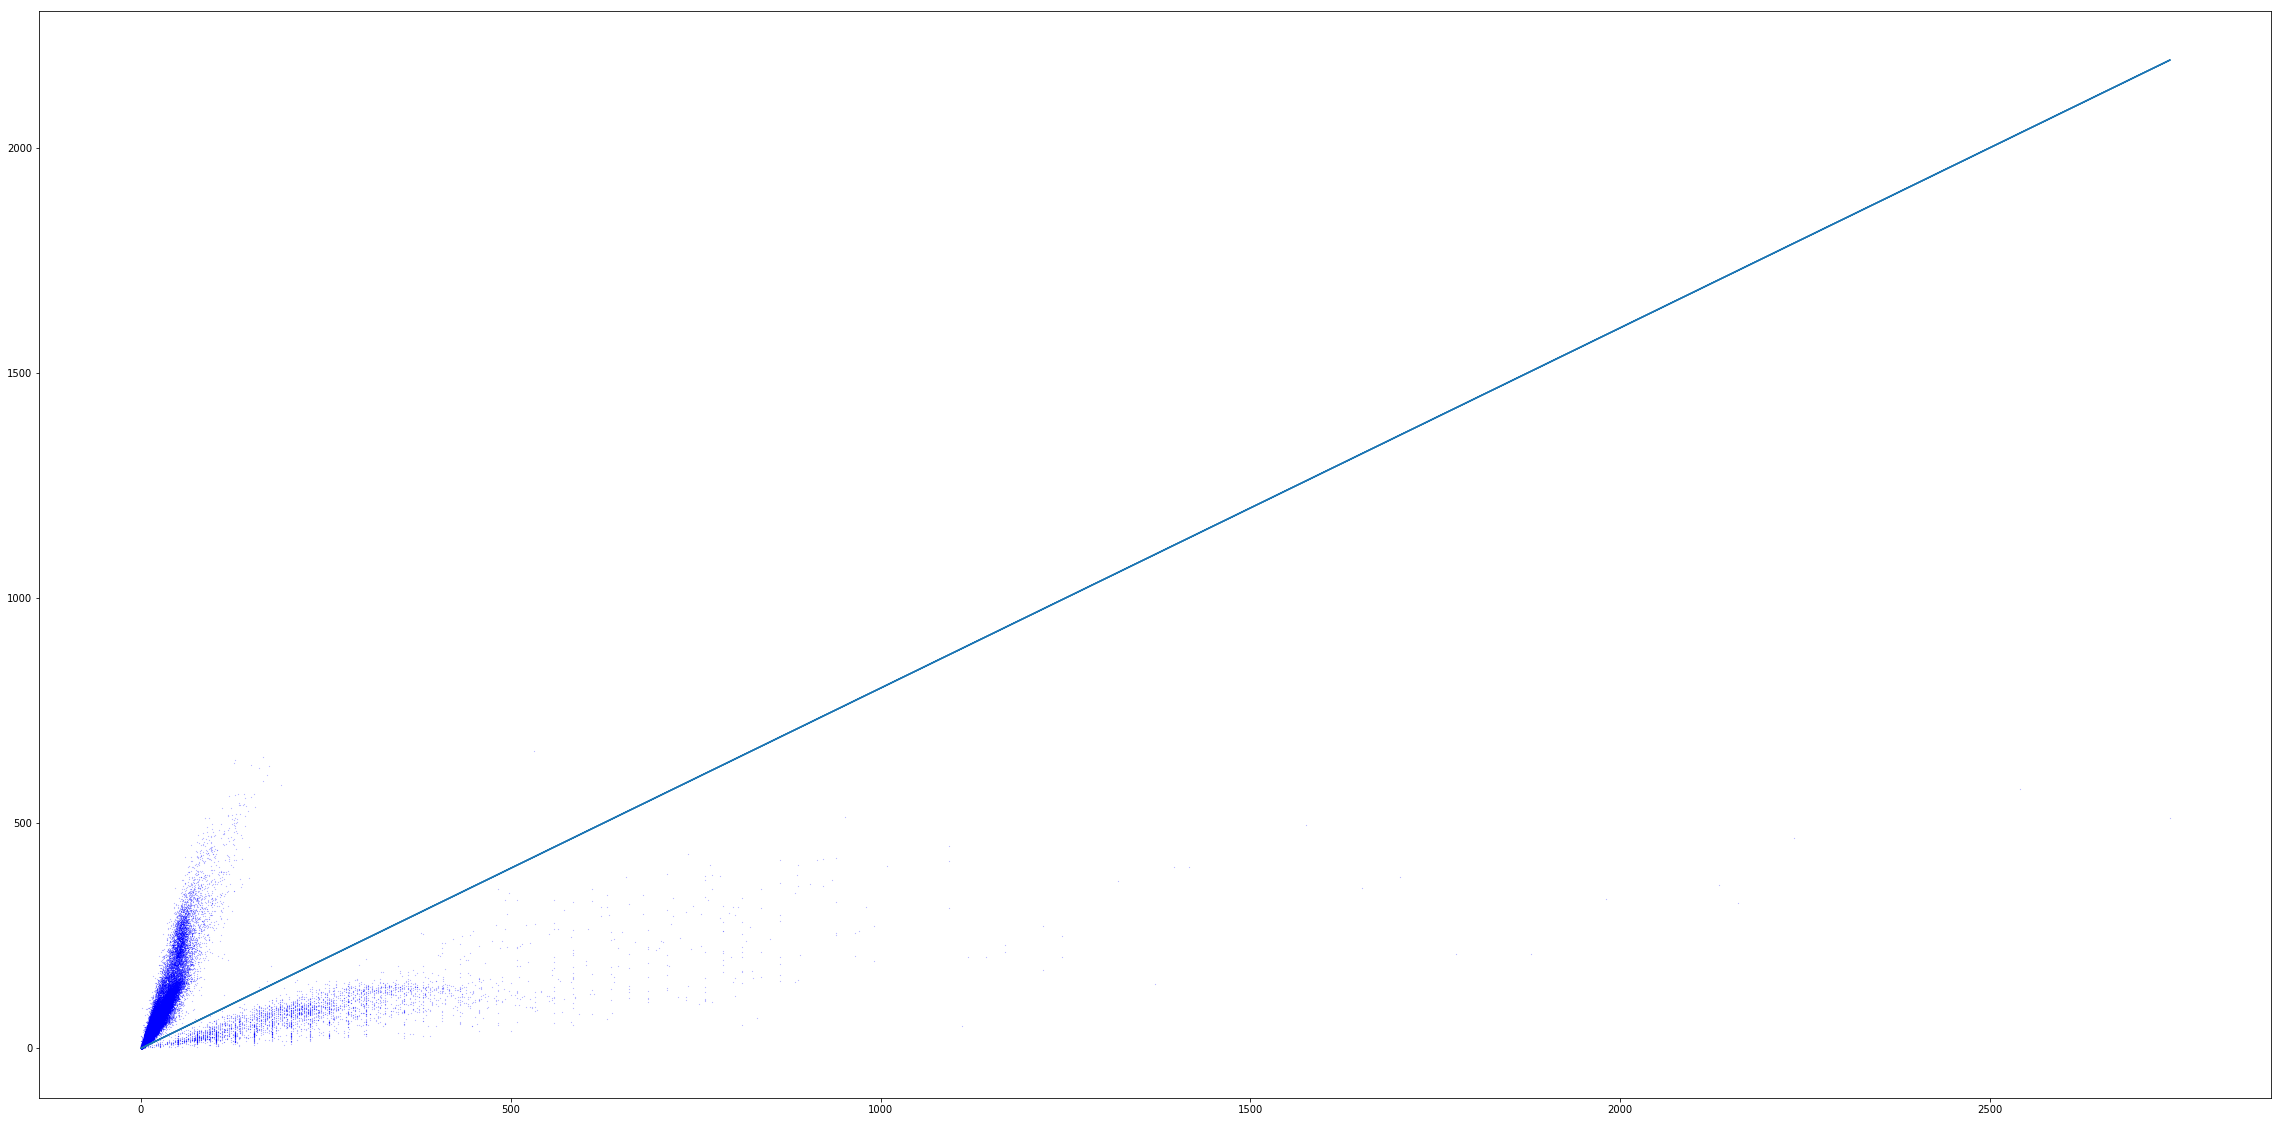

In [25]:
ax = plt.figure(1,figsize = (40,20))
ax =plt.plot(Y_train,X_train['PRCP'],'bo',markersize = 0.1)
ax = plt.plot(Y_train,0.8*Y_train)
#ax = plt.plot(np.arange(0,X_train.shape[0]),Y_train,'ro')
plt.show()

### Create the clusters

In [44]:
def higher(x,y,t):
    if x<=t*y:
        return 1
    else:
        return 0

In [45]:
X = pd.concat([X_train['PRCP'],Y_train],axis=1)
X_train['CLUSTERS'] = X.apply(lambda x: higher(x['PRCP'],x['VALUE'],0.8),axis = 1)

In [28]:
X_train.to_csv('x_train.csv')

In [29]:
X = pd.concat([X_test['PRCP'],Y_test],axis=1)
X_test['CLUSTERS'] = X.apply(lambda x: higher(x['PRCP'],x['VALUE'],0.8),axis = 1)

In [30]:
a = Y_train[X_train[X_train['CLUSTERS']==1].index].mean()

In [31]:
b = Y_train[X_train[X_train['CLUSTERS']==0].index].mean()

In [32]:
c = a/b
c

10.270440561400036

In [33]:
Y_train[X_train[X_train['CLUSTERS']==1].index] = Y_train[X_train[X_train['CLUSTERS']==1].index]/25.4

In [34]:
Y_test[X_test[X_test['CLUSTERS']==1].index] = Y_test[X_test[X_test['CLUSTERS']==1].index]/25.4

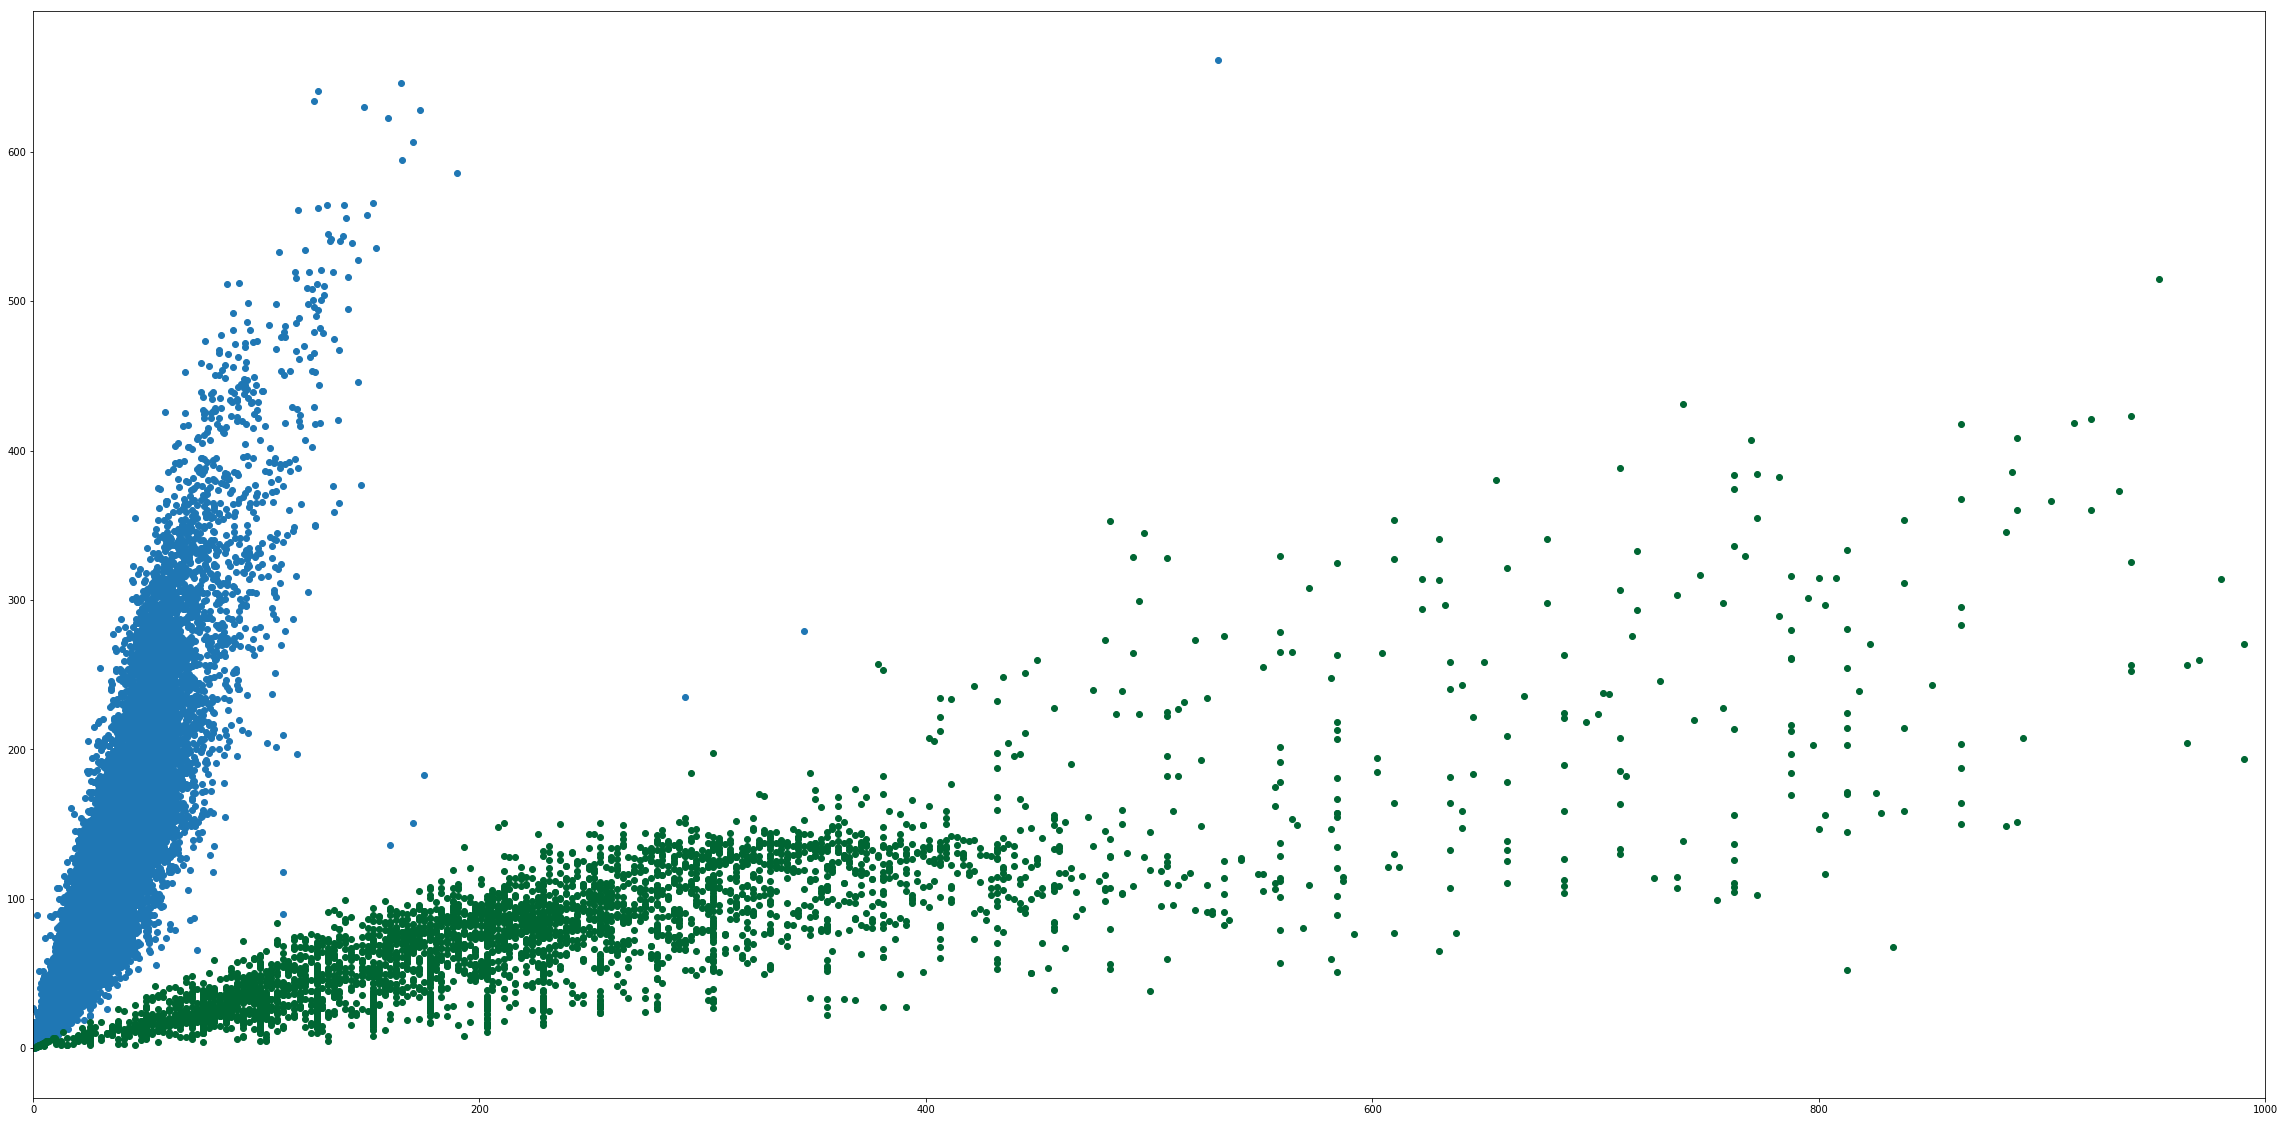

In [53]:
ax = plt.figure(1,figsize = (40,20))
ax =plt.plot(Y_train[X_train[X_train['CLUSTERS']==0].index],X_train[X_train['CLUSTERS']==0]['PRCP'],'o',color = (0,102/255,51/255))
ax =plt.plot(Y_train[X_train[X_train['CLUSTERS']==1].index],X_train[X_train['CLUSTERS']==1]['PRCP'],'o',color = (0,102/255,51/255))
#ax = plt.plot(np.arange(0,X_train.shape[0]),Y_train,'ro')
plt.xlim((0,1000))
plt.show()

### Ploting the two clusters on a map

In [711]:
X_train['Coordinates'] = X_train.apply(lambda x: (x['LONGITUDE'],x['LATITUDE']),axis=1)

In [712]:
X_train['Coordinates'] = X_train['Coordinates'].apply(Point)

In [713]:
gdf = geopandas.GeoDataFrame(X_train, geometry='Coordinates')

<Figure size 2880x1440 with 0 Axes>

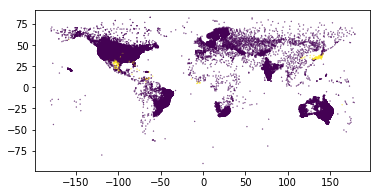

In [714]:
ax = plt.figure(1,figsize = (40,20))
ax = gdf.plot(column = 'CLUSTERS',markersize = 0.1)
plt.show()


In [715]:
X_train.drop(columns=['Coordinates'],inplace = True)

In cluster 1, few value randomly distributed

### Creating a classifier to find these clusters in the test

<div class="alert alert-block alert-danger"> Do not run just ignore these values is enough </div>

In [133]:
Yc = X_train['CLUSTERS']
Xc = X_train.drop(columns = ['CLUSTERS'])

In [134]:
X_train[X_train['CLUSTERS'] == 1].shape

(4025, 85)

In [135]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, Yc, test_size=0.1)

In [136]:
classifier = LogisticRegression()
classifier.fit(Xc_train,yc_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [137]:
yc_pred = classifier.predict(Xc_test)

In [138]:
Xc_test['CLUSTERS'] = yc_pred

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [139]:
accuracy_score(yc_test,yc_pred)

0.9152715394038383

In [140]:
X_test['CLUSTERS'] = classifier.predict(X_test.drop(columns = ['CLUSTERS']))

### Model Selection

<div class="alert alert-block alert-success"> <h1><b><center>START RUNING AGAIN </center></b></h1></div>

#### Subset selection

In [255]:
drops = [[],['TAVG'],['PRCP'],['TAVG','PRCP']]
Acc = []
for d in drops:
    X = X_train.drop(columns = d)
    model = RandomForestRegressor(100)
    cv = cross_validate(model,X,Y_train,cv=7,verbose = 1,n_jobs = -1)
    Acc.append(cv['test_score'].mean())
drop = drops[np.argmax(Acc)]
print('We eliminate the following variables:',drop)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  5.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   38.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


We eliminate the following variables: ['TAVG']


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  5.3min finished


In [256]:
X_train.drop(columns = drop,inplace = True)
X_test.drop(columns = drop,inplace = True)

<p>January: drop = []</p>
<p>February: drop = ['TAVG']</p>
<p>March: drop = []</p>
<p>April: drop = ['TAVG']</p>
<p>May: drop = []</p>
<p>June: drop = []</p>
<p>July: drop = ['TAVG']</p>
<p>August: drop = []</p>
<p>September: drop = ['TAVG']</p>
<p>October: drop = ['TAVG']</p>
<p>November: drop = ['TAVG','PRCP']</p>
<p>December: drop = []</p>

#### GridSearch

In [257]:
parameters = {"max_depth": np.arange(20,100,10)}
RF_model = RandomForestRegressor(100,bootstrap=True)
clf = GridSearchCV(RF_model, parameters, cv=10,verbose = 20, n_jobs = -1)
clf.fit(X_train,Y_train)
print(clf.best_score_)
print('-----------------------------------------------------------------------')
print(clf.best_params_)
max_depth = clf.best_params_['max_depth']

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

0.8151932410133664
-----------------------------------------------------------------------
{'max_depth': 20}


### Creating the regressor

In [258]:
RF_model = RandomForestRegressor(100,max_depth=max_depth,bootstrap = True,n_jobs = -1)
RF_model.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [259]:
feat_importance = RF_model.feature_importances_

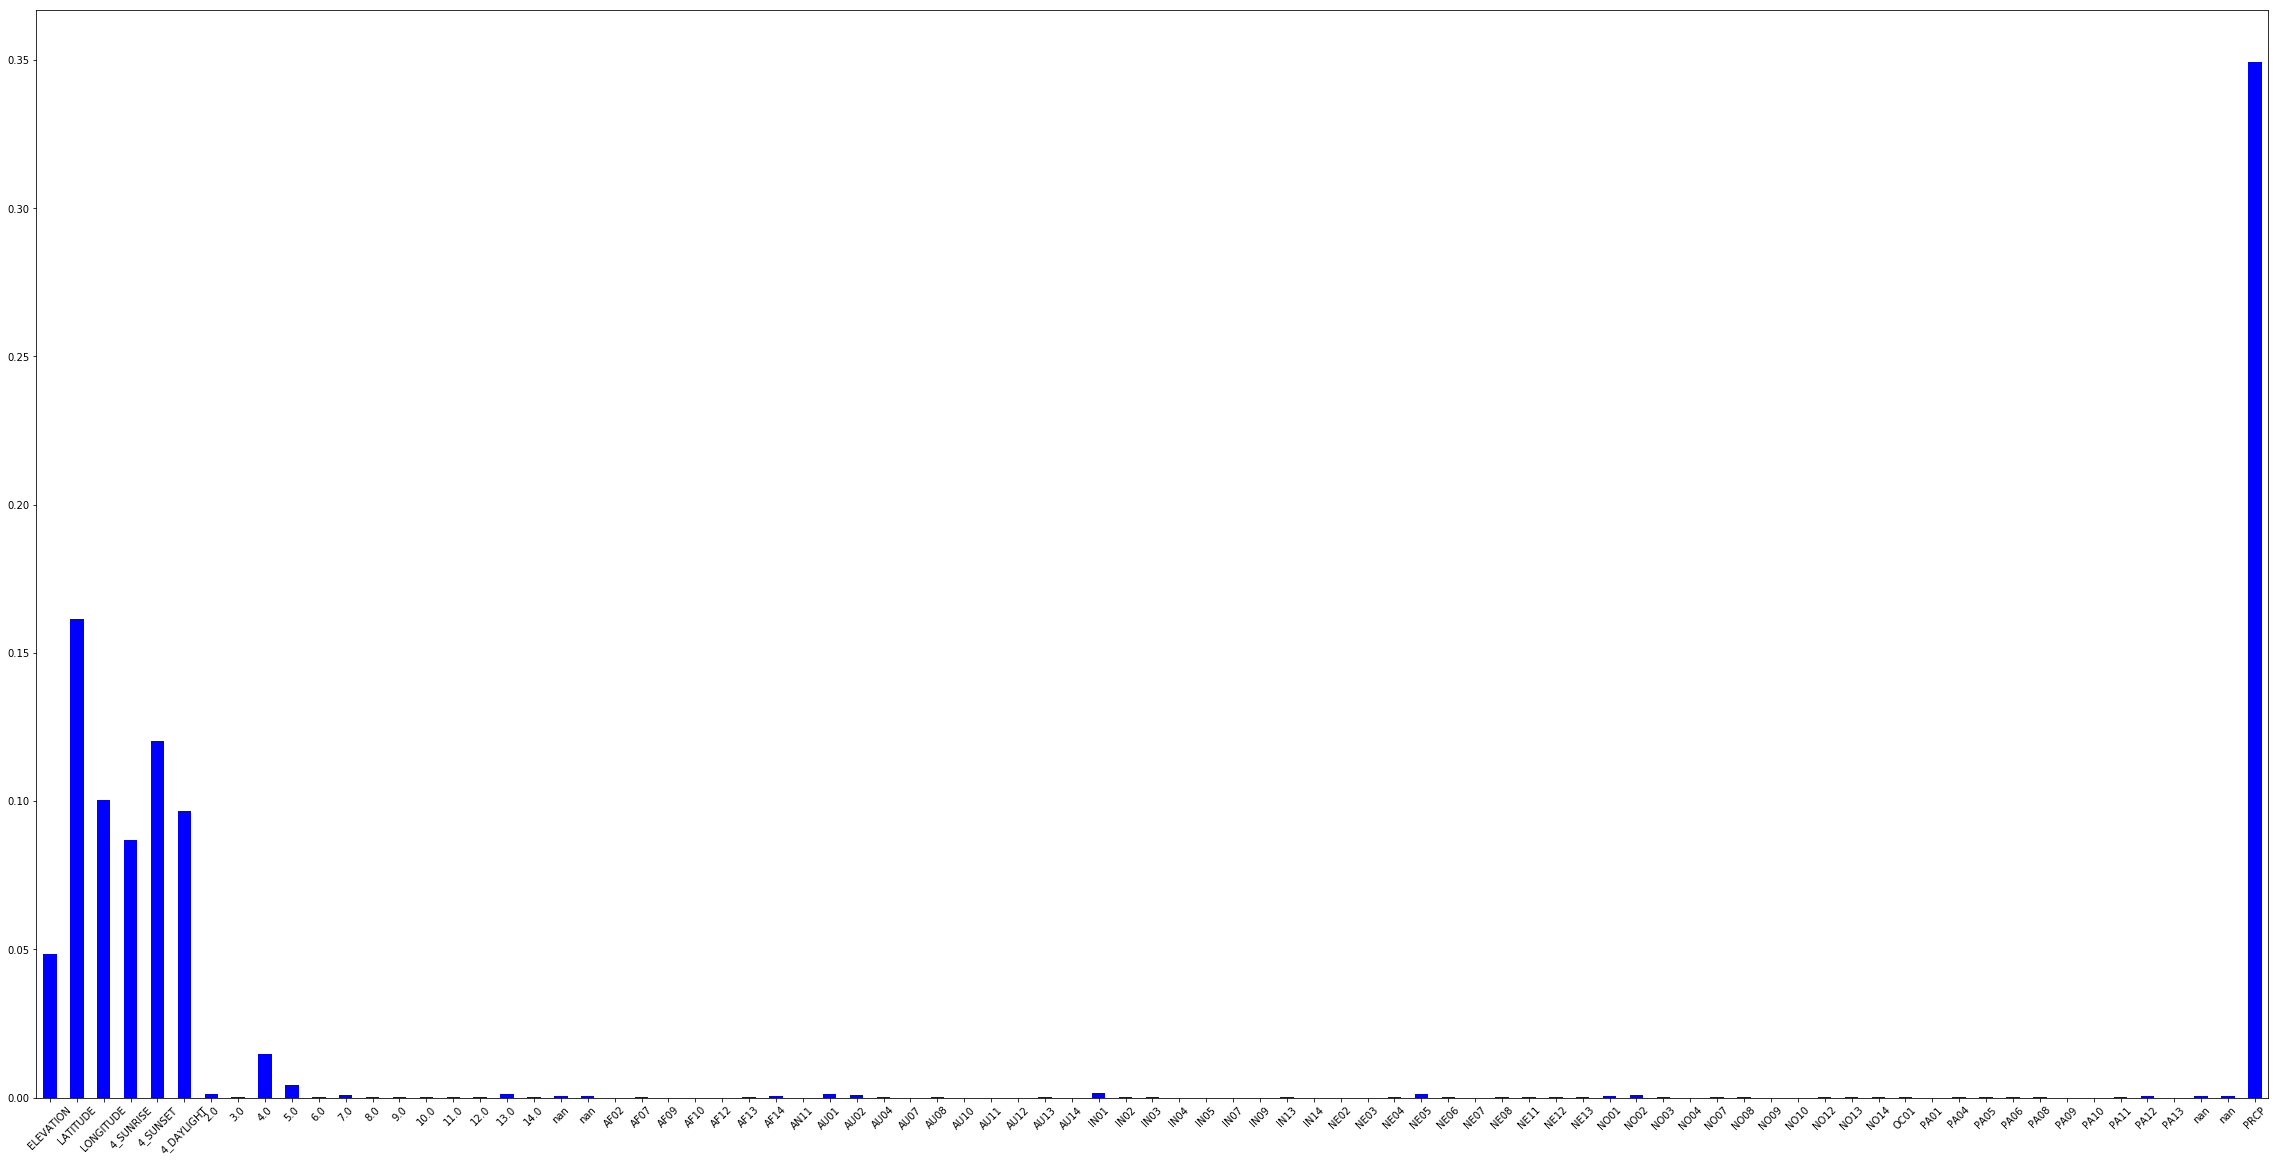

In [260]:
ax = plt.figure(1, figsize = (40,20))
df = pd.Series(feat_importance,index = X_train.columns)
ax = df.plot(kind = 'bar', rot = 45, color = 'b')

In [261]:
Y_pred_train = RF_model.predict(X_train)
Y_pred = RF_model.predict(X_test)

In [262]:
r2_score(Y_train,Y_pred_train)

0.954123267122744

In [263]:
r2_score(Y_test,Y_pred)

0.8149441871621756

In [264]:
pickle.dump(RF_model, open( './models/'+str(month).zfill(2)+'-'+variable+'_model.p', "wb" ))

### Def the Inverse Distance Methode class

In [218]:
class IDM:
    def __init__(self,k,metric = None):
        if metric is None:
            self.metric = 'haversine'
        else :
            self.metric = metric
        self.k = k
        
    def fit(self,x,y, y_pred):
        self.model = NearestNeighbors(n_neighbors = self.k,metric = self.metric)
        self.model.fit(x)
        self.res = y - y_pred
        
    def predict(self, x, y, f=None):
        dist, idx = self.model.kneighbors(x)
        res = self.res
        if f is None:
            def f(x):
                return x
        if self.metric == 'haversine':
            dist = dist*6371
        res_k = []
        for i in range(len(idx)):
            res_k.append(res[idx[i]])
        res_k = np.array(res_k)[:,1:]
        dist = dist[:,1:]
        IDP = (res_k/f(dist)).sum(axis = 1)
        IDP = np.where((IDP <3*res.std()) & (IDP >-3*res.std()),IDP,0)
        return y + IDP
    
    def best_estim(self, x, y, y_pred, k_first, k_last):
        model = NearestNeighbors(n_neighbors = k_last,metric = self.metric)
        model.fit(x)
        res = y - y_pred
        dist, idx = model.kneighbors(x)
        res_k = []
        for i in range(len(idx)):
            res_k.append(res[idx[i]])
        res_k = np.array(res_k)[:,1:]
        dist = dist[:,1:]
        r2_list = list()
        progress = IntProgress(min=k_first, max=k_last,description="n:",bar_style="info")
        display(progress)
        progress.value = 0
        for k in range(k_first, k_last+1):
            progress.value += 1
            dist_k = dist[:,:k]
            res_k_1 = res_k[:,:k]
            IDP = (res_k_1/dist_k).sum(axis = 1)
            IDP = np.where((IDP <3*res.std()) & (IDP >-3*res.std()),IDP,0)
            r2_list.append(r2_score(y,y_pred + IDP))
        return r2_list
            
        

### Get the points coordinates in radians

In [219]:
points_train = X_train[['LATITUDE','LONGITUDE']].apply(lambda x: [radians(x['LATITUDE']),radians(x['LONGITUDE'])],axis=1,result_type = 'expand')
points_train.columns = ['LATITUDE','LONGITUDE']

In [220]:
points_test = X_test[['LATITUDE','LONGITUDE']].apply(lambda x: [radians(x['LATITUDE']),radians(x['LONGITUDE'])],axis=1,result_type = 'expand')
points_test.columns = ['LATITUDE','LONGITUDE']

### Fitting and predicting idm

In [221]:
idm_inst = IDM(2)
scores = idm_inst.best_estim(points_train, Y_train, Y_pred_train, 2,100)

IntProgress(value=2, bar_style='info', description='n:', min=2)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:36: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:36: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launche

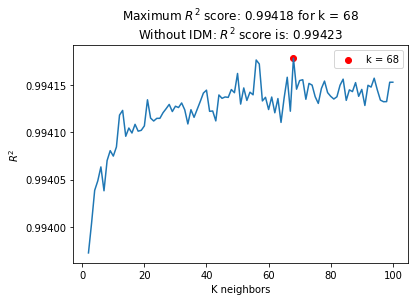

In [222]:
plt.plot(np.arange(2, 101, 1),scores)
plt.xlabel('K neighbors')
plt.ylabel('$R^{2}$')

k_opt = np.arange(2, 101, 1)[np.argmax(scores)]
plt.scatter(k_opt, scores[np.argmax(scores)], color = 'red', label = 'k = %s' %k_opt)
plt.title('Maximum $R^{2}$ score: %s for k = %s \nWithout IDM: $R^{2}$ score is: %s' %(round(scores[np.argmax(scores)],5), k_opt, round(r2_score(Y_train,Y_pred_train),5)))
plt.legend()
plt.show()

In [227]:
idm = IDM(68)
idm.fit(points_train,Y_train, Y_pred_train)

In [228]:
def f(x):
    return np.log(x)

In [229]:
y_pred_idp = idm.predict(points_test.values,Y_pred)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:36: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


In [230]:
print('Acc without idm:',r2_score(Y_test,Y_pred),'\nAcc with idm',r2_score(Y_test,y_pred_idp))


Acc without idm: 0.9116772074831465 
Acc with idm 0.9121030361621316
